# Introduction
The research questions is as follows: <br>
<br>
How different variables such as **actual delivery time**, **the difference between actual and estimated wait time**, **order status**, **freight value**, **payment value**, **payment installment** affect the **review score** in each of the different **product type categories**, `Houseware`, `auto`, `furniture decor`, `computer accessories`, `health beauty`, `sports leisure`? <br>

In this python notebook, the `max_depth` and `n_estimators` obtained from the GV search is run into random forest to obtain the classification accuracy, true positive, true negative, false positive, false negative values. 

All the extracting and cleaning codes are similar to earlier parts. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv")
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv")
olist_order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv")
olist_products_dataset = pd.read_csv("olist_products_dataset.csv")
product_category_name_translation = pd.read_csv("product_category_name_translation.csv")

### Merging the Datasets

In [3]:
olist_merge = olist_orders_dataset.merge(olist_order_reviews_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_payments_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_order_items_dataset, on="order_id", how = 'left')
olist_merge = olist_merge.merge(olist_products_dataset, on="product_id", how = 'left')

### Removing Duplicates and extracting needed variables 

In [4]:
olist_merge.drop_duplicates(subset=["review_score", "order_id"], inplace = True)

In [5]:
dataAnalysis = pd.DataFrame(olist_merge[['order_status','order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_score', 'payment_installments', 'payment_value', 'freight_value', 'product_category_name']])

In [6]:
# Creating a list of the time related variables 
time = ["order_purchase_timestamp","order_estimated_delivery_date","order_delivered_customer_date", "order_approved_at"]
# Changing the time related variables to datetime format using the list 
for column in time:
    dataAnalysis.loc[:, column] = pd.to_datetime(dataAnalysis[column])

In [7]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"actual_wait_time"] = (dataAnalysis['order_delivered_customer_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [8]:
# Calculating the estimated wait time 
dataAnalysis.loc[:,"estimated_wait_time"] = (dataAnalysis['order_estimated_delivery_date']-dataAnalysis['order_purchase_timestamp']).dt.days

In [9]:
#Actual minus estimated wait time 
dataAnalysis.loc[:,"actualxestimated"] = (dataAnalysis['actual_wait_time']-dataAnalysis['estimated_wait_time'])

In [10]:
dataAnalysis.drop(columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'estimated_wait_time'], inplace = True)

In [11]:
dataAnalysis = dataAnalysis.loc[(dataAnalysis["order_status"]=="delivered")]

In [12]:
# Calculating the actual wait time    
dataAnalysis.loc[:,"reviewscore"] = dataAnalysis["review_score"]//3

In [13]:
# Original review score no longer needed
dataAnalysis.drop(columns = ['review_score'], inplace = True)

In [14]:
#merging with english name first 
dataAnalysis = pd.merge(dataAnalysis,product_category_name_translation,how="left",on="product_category_name")

In [15]:
housewareProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="housewares")]

# Defining a balance function to balance the two classes
def balancing(dataframe):
    # Class count
    count_class_1, count_class_0 = dataframe.reviewscore.value_counts() #split the dataframe based on review scores into 1 and 0

    # Divide by class 1 and 0 to create two different dataframes
    df_class_0 = dataframe[dataframe['reviewscore'] == 0] 
    df_class_1 = dataframe[dataframe['reviewscore'] == 1]

    #Sample the class 0 (review score 0) by the number of review 1s
    df_class_0_over = df_class_0.sample(count_class_1, replace=True)
    dataframe = pd.concat([df_class_1, df_class_0_over], axis=0)
    return dataframe #return the dataframe

housewareProd = balancing(housewareProd)
# since there is no null values, no further cleaning is required. 

In [16]:
autoProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="auto")]

In [17]:
#Needs cleaning and removal of null values 
autoProd = autoProd.loc[(autoProd["actual_wait_time"].notnull())]
autoProd=balancing(autoProd)

In [18]:
#No need further cleaning
furnitureProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="furniture_decor")]
furnitureProd = balancing(furnitureProd)

In [19]:
CompAcProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="computers_accessories")]

In [20]:
#Needs cleaning and removal of null values 
CompAcProd = CompAcProd.loc[(CompAcProd["actual_wait_time"].notnull())]
CompAcProd=balancing(CompAcProd)

In [21]:
healthProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="health_beauty")]

In [22]:
#Needs further cleaning 
healthProd = healthProd.loc[(healthProd["payment_installments"].notnull())]
healthProd=balancing(healthProd)

In [23]:
sportsProd = dataAnalysis.loc[(dataAnalysis["product_category_name_english"]=="sports_leisure")]

In [24]:
#Needs further cleaning 
sportsProd = sportsProd.loc[(sportsProd["actual_wait_time"].notnull())]
sportsProd=balancing(sportsProd)

#### Creating function for random forest on the product types with parameters estim and mdepth

In [25]:
def train_and_predict(dataframe, estim, mdepth):
    # Import essential models and functions from sklearn
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix

    # Extract Response and Predictors
    y = pd.DataFrame(dataframe['reviewscore'])
    X = pd.DataFrame(dataframe[["payment_installments", "payment_value", "freight_value", "actual_wait_time", "actualxestimated"]]) 

    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

    # Import RandomForestClassifier model from Scikit-Learn
    from sklearn.ensemble import RandomForestClassifier

    # Create the Random Forest object
    rforest = RandomForestClassifier(n_estimators = estim,  # n_estimators denote number of trees
                                     max_depth = mdepth)       # set the maximum depth of each tree

    # Fit Random Forest on Train Data
    rforest.fit(X_train, y_train.reviewscore.ravel())

    # Predict the Response corresponding to Predictors
    y_train_pred = rforest.predict(X_train)
    y_test_pred = rforest.predict(X_test)
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model: Train Dataset")
    print("Classification Accuracy : ", rforest.score(X_train, y_train))
    confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
    TN = confusion_matrix_train[0,0]
    TP = confusion_matrix_train[1,1]
    FP = confusion_matrix_train[0,1]
    FN = confusion_matrix_train[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ", FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model: Test Dataset")
    print("Classification Accuracy : ", rforest.score(X_train, y_train))
    confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
    TN = confusion_matrix_test[0,0]
    TP = confusion_matrix_test[1,1]
    FP = confusion_matrix_test[0,1]
    FN = confusion_matrix_test[1,0]
    print("True Negative Rate      : ", TN/(TN+FP))
    print("True Positive Rate      : ", TP/(TP+FN))
    print("False Negative Rate     : ",FN/(FN+TP))
    print("False Positive Rate     : ", FP/(TN+FP))

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.996383726770467
True Negative Rate      :  1.0
True Positive Rate      :  0.9928172386272945
False Negative Rate     :  0.007182761372705506
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.996383726770467
True Negative Rate      :  0.9970484061393152
True Positive Rate      :  0.9224615384615384
False Negative Rate     :  0.07753846153846154
False Positive Rate     :  0.0029515938606847697


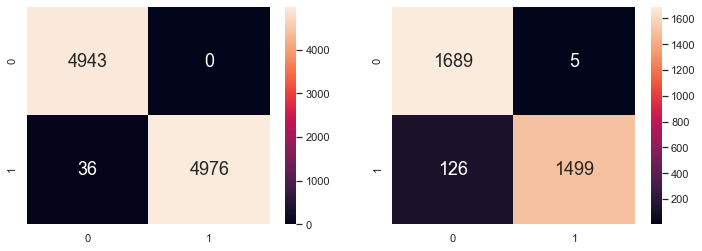

In [26]:
train_and_predict(sportsProd, 10, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9953445065176909
True Negative Rate      :  0.9997358689910195
True Positive Rate      :  0.9908896034297964
False Negative Rate     :  0.009110396570203644
False Positive Rate     :  0.0002641310089804543

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9953445065176909
True Negative Rate      :  0.9975530179445351
True Positive Rate      :  0.89921875
False Negative Rate     :  0.10078125
False Positive Rate     :  0.0024469820554649264


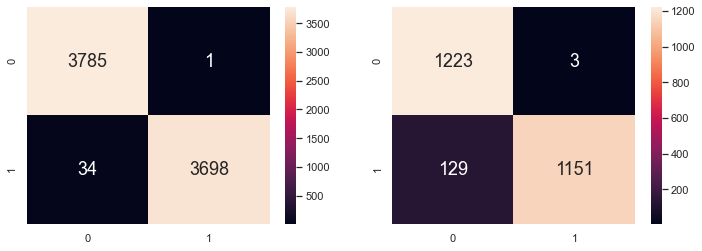

In [27]:
train_and_predict(housewareProd, 10, 400)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9959769109672906
True Negative Rate      :  1.0
True Positive Rate      :  0.9919832694318578
False Negative Rate     :  0.00801673056814221
False Positive Rate     :  0.0

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9959769109672906
True Negative Rate      :  0.9984431759211209
True Positive Rate      :  0.9230769230769231
False Negative Rate     :  0.07692307692307693
False Positive Rate     :  0.0015568240788790867


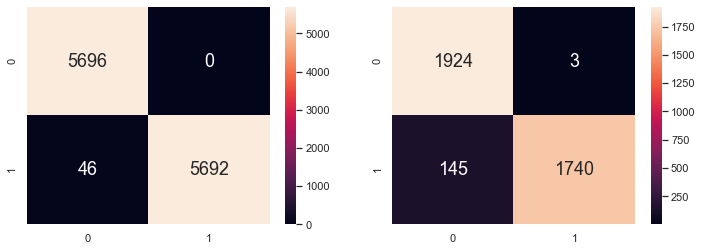

In [28]:
train_and_predict(healthProd, 10, 800)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9973710819009101
True Negative Rate      :  0.9991935483870967
True Positive Rate      :  0.9955375253549695
False Negative Rate     :  0.004462474645030426
False Positive Rate     :  0.0008064516129032258

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9973710819009101
True Negative Rate      :  0.99265605875153
True Positive Rate      :  0.9002403846153846
False Negative Rate     :  0.09975961538461539
False Positive Rate     :  0.0073439412484700125


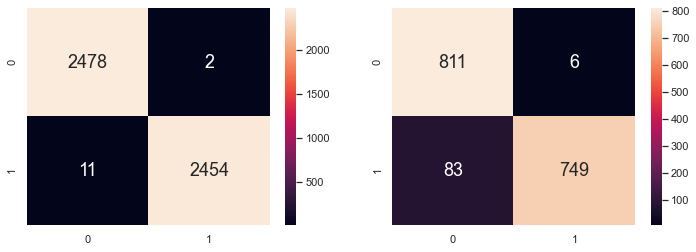

In [29]:
train_and_predict(autoProd, 10, 500)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9954425521707844
True Negative Rate      :  0.9990460290961126
True Positive Rate      :  0.9917973462002413
False Negative Rate     :  0.008202653799758746
False Positive Rate     :  0.0009539709038874314

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9954425521707844
True Negative Rate      :  0.9831625183016105
True Positive Rate      :  0.8734087694483734
False Negative Rate     :  0.1265912305516266
False Positive Rate     :  0.01683748169838946


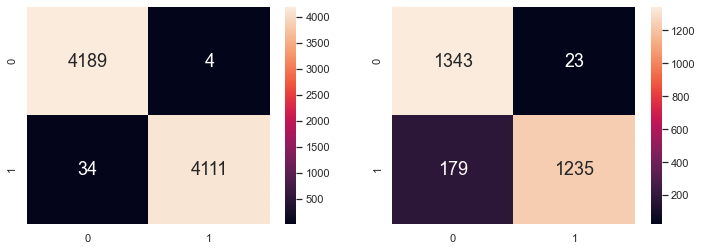

In [30]:
train_and_predict(CompAcProd, 10, 500)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9943124368048534
True Negative Rate      :  0.9992433795712484
True Positive Rate      :  0.9893590068406385
False Negative Rate     :  0.010640993159361541
False Positive Rate     :  0.0007566204287515763

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9943124368048534
True Negative Rate      :  0.9900763358778626
True Positive Rate      :  0.8576807228915663
False Negative Rate     :  0.14231927710843373
False Positive Rate     :  0.009923664122137405


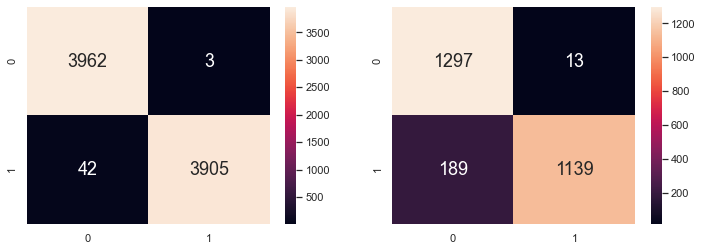

In [31]:
train_and_predict(furnitureProd, 10, 200)

Goodness of Fit of Model: Train Dataset
Classification Accuracy :  0.9979909593169262
True Negative Rate      :  0.9993946731234867
True Positive Rate      :  0.9965993198639728
False Negative Rate     :  0.0034006801360272052
False Positive Rate     :  0.0006053268765133172

Goodness of Fit of Model: Test Dataset
Classification Accuracy :  0.9979909593169262
True Negative Rate      :  0.992266508030934
True Positive Rate      :  0.9578754578754579
False Negative Rate     :  0.04212454212454213
False Positive Rate     :  0.007733491969066032


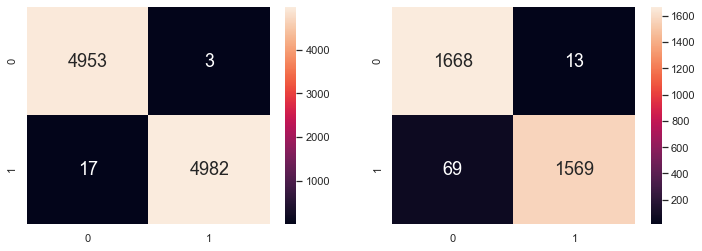

In [32]:
train_and_predict(sportsProd, 13, 900)

In [33]:
tain_and_predict(housewareProd, 13, 600)

NameError: name 'tain_and_predict' is not defined

In [ ]:
train_and_predict(healthProd, 13, 800)

In [ ]:
train_and_predict(autoProd, 13, 300)

In [ ]:
train_and_predict(CompAcProd, 13, 700)

In [ ]:
train_and_predict(furnitureProd, 13, 900)

# Check Point: Analysis 


After feeding in the best hyperparameters obtained through the GV Search, it can be seen that the train and test classification accuracy is very similar. This suggests that no overfitting occurred. Overfitting occurs when the train dataset has good classification accuracy, true positive and true negative but terrible classification accuracy, true positive and true negative when test data is used. In the above scenario, the classification accuracy, true positive and true negative is similar for both test and train. Hence no overfitting occurred. 

However, classification accuracy, true positive and true negative is still very high and this could be due to the upsamlping of review score 0 done earlier. Upscaling does lead to overfitting. 

# In Conclusion and summary to the entire project, 
A decision tree (part 6) is a basic machine learning tool that did not provide a very high classification accuracy(65% to 75%), true positive(60% to 85%) and true negative(50% to 60%). There was a large distribution of these values across product types too. Every time the notebook is run, the train and test classification accuracy would differ from a range of 1% to 10%. Additionally, false positive was above 40% for most product types across multiple runs of the ipynb. This shows that the machine learning tool was not the best. 

Another option was to run random forest. A random forest uses a 'forest', a multitude of decisions trees that help to classify the data points into the different review scores. The reason why random forest works so well is that "A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models."
Taken from: https://towardsdatascience.com/understanding-random-forest-58381e0602d2 

There is low correlation between the trees and the trees help to cover each others errors to enable the most accurate classification. Hence we see that the random forest does enable better classification in part 7. Classification accuracy increase above 80% and false positive rates fell below 30%. Train and test were similar in terms of classification accuracy. 
False positives are generally bad given our reseach question. This is because sellers want to adjust their **actual delivery time**, **the difference between actual and estimated wait time**, **order status**, **freight value**, **payment value**, **payment installment** such that they obtain the best review score 1 which is translated to 3 to 5 review score. If the adjust these factors and get a false positive, then they may predict a high review score but end up getting a low one. 

Hence, although the classification accuracy is relatively better, an additional step must be done to reduce the false positive. Tuning of hyperparameters must be done to achieve the highest possible classification accuracy, true positive and true negative and lowest possible false positive and false negative. Hyperparameters are used to make the random forest. There are many hyperparameters but for the scope of this project max_depth and n_estimators were chosen. max_depth is the maximum depth each decision tree goes in the 'forest' of trees. n_estimators is the number of trees in the forest. 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

To find the best hyperparemeters a Grid Search is done. Resources are as follows:
https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
https://neptune.ai/blog/hyperparameter-tuning-in-python-a-complete-guide-2020#:~:text=Hyperparameter%20tuning%20is%20the%20process,maximum%20performance%20out%20of%20models.
https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
https://stackoverflow.com/questions/50232599/interpreting-sklearns-gridsearchcv-best-score

Grid Search will then run a range for the hyperparameters as seen in part 7. The definition provided by Sci-Kit is "The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid." 
Cross validation is defined as "Cross validation is a statistical method used to estimate the performance (or accuracy) of machine learning models." ~ https://www.mygreatlearning.com/blog/cross-validation/ 

Best score is the "Mean cross-validated score of the best_estimator". Since cv = 5, the train and test split will occur five times for each hyperparameter. The best score is calculated for each try and for each combination of hyperparameters. The best score will return the average of the best hyperparameter combination in those 5 tries. 

This function will return the best hyperparameters max_depth and n_estimators. These are then run into the random forest in this very ipynb. Seen from above, classification accuracy, true positive and true negative are above 95% and false positive and false negative are below 1% for all product types. Train and test data are very similar. Hence, there is no overfitting as explained earlier. 
